In [20]:
import tensorflow as tf
#https://medium.com/%E8%BB%9F%E9%AB%94%E4%B9%8B%E5%BF%83/%E9%81%A9%E5%90%88%E5%A4%A7%E9%87%8F%E8%B3%87%E6%96%99i-o%E7%9A%84%E5%84%B2%E5%AD%98%E6%A0%BC%E5%BC%8F-tfrecord%E7%B0%A1%E4%BB%8B%E8%88%87%E6%93%8D%E4%BD%9C%E6%95%99%E5%AD%B8-cd27e50d51ee

# mnist one example consists of 28*28 byte + 1 byte
# if _bytes_feature's args is alreaddy a list, no need to use []
def _image_feature(value):
    """"Returns a uint8(byte)_list from a byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _label_feature(value):
    """Returns a uint8(byte)_list from a byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [43]:
""" transfer dataset to tfrecord method"""
# the whole image is a byte feature, not a byte list
import os
import struct                                                                   
import numpy as np                                                              
import matplotlib.pyplot as plt                                                 
from PIL import Image
from queue import PriorityQueue as PQ
def serialize_example(_label, _image):
    feature = {
        "label": _label_feature(_label),
        "image": _image_feature(_image),
        }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString() 

images_file_name = './train-images.idx3-ubyte'
labels_file_name = './train-labels.idx1-ubyte'
images_dir = './mnist jpeg/'
oft_file_name='mnist-sparse_padded_BFD-offset_table'
tfr_file_name='mnist_sparse_padded_BFD.tfrecords'
mnist_images=open(images_file_name,'rb')
mnist_labels=open(labels_file_name,'rb')
# skip header file
_=mnist_images.read(16)
_=mnist_labels.read(8)

# data
# build offset_table while writing TFRecords, int64 for offset of each instance, e.g. offset of instance #100 is 100*8B=800B
# byte is little endian
offset_table=open(oft_file_name,'wb') 

"""
class Bin(object):
    # Container for items that keeps a running sum 
    def __init__(self):
        self.items = []
        self.sum = 0

    def append(self, item):
        self.items.append(item)
        self.sum += item.w

    def __str__(self):
        # Printable representation 
        return 'Bin(sum=%d, items=%s)' % (self.sum, str(self.items))

class Instance(object):
    def __init__(self):
        # idx: original idx in the file
        self.idx=-1
        self.w=0
"""

# BFD algorithm, input: all instances; output: BFD order (e.g. [0,2,1] means in rewrited dataset the order is ins #0 #2 #1)
# items contains [w,idx] of each item, remain_w in front for sorting
# bins contains idx of instances inside it (e.g. [[0,1,3],[2,4,5]] means bin1 has ins #0 #1 #3)
# bins_remain_w contains [remain_w,bin_idx] of each bin, remain_w in front for sorting

# bins contains [remain_w,[item_idx]]
items=[]

#bins_remain_w=[]

# pre BFD
# know the length of each instance
for i in range (60000):
    len_record=0
    if(i%4000==0):
        print(i,end=' ')
    with open(images_dir+str(i)+'.jpg','rb') as f:
        buf=mnist_labels.read(1)
        _label=buf
        img_bytes=f.read()
        serialized_example = serialize_example(_label, img_bytes)
        # 16B metadata
        len_record=len(serialized_example)+16        
    item=[len_record,i]
    items.append(item)

# BFD step 1: sort all items, heaviest first
items.sort()
items.reverse()



0 4000 8000 12000 16000 20000 24000 28000 32000 36000 40000 44000 48000 52000 56000 

In [45]:
import time
# BFD step 2: For each item, find a bin with the maximum load into which the item can fit, if any.
#TODO: O(N^2) implementation, use binary search to achieve O(NlogN), 手刻可能比較快
# initialize first bin
bins=[]
A=[4096,[]]
bins.append(A)
c=0
start_t=time.time()
for item in items:
    
    #print("processing item ",item[1])
    
    c+=1
    if(c%2000==0):
        end_t=time.time()
        print(c,end_t-start_t)
        start_t=time.time()
    no_bin=True
    for B in bins:
        # if B has enough space, put item into B, break
        if B[0]>=item[0]:
            B[0]-=item[0]
            B[1].append(item[1])
            no_bin=False
            break
    # if no bins is big enough for item, open a new one
    if no_bin:
        A=[4096-item[0],[item[1]]]        
        bins.append(A)
    bins.sort()
c=0
for B in bins:
    #print(len(B[1]))
    c+=len(B[1])
print(c)
#print(bins[:10])
#print(bins[-10:])
# If such a bin is found, the new item is placed inside it.
# Otherwise, a new bin is opened and the coming item is placed inside it.

2000 0.07555270195007324
4000 0.1880054473876953
6000 0.325986385345459
8000 0.4867067337036133
10000 0.525585412979126
12000 0.6290006637573242
14000 0.741999626159668
16000 0.8637411594390869
18000 1.0690157413482666
20000 1.099003791809082
22000 1.318619728088379
24000 1.3610000610351562
26000 1.527590274810791
28000 1.7871003150939941
30000 2.113316297531128
32000 2.1798694133758545
34000 2.221944808959961
36000 2.4971282482147217
38000 2.558633804321289
40000 2.803603410720825
42000 3.080460786819458
44000 3.237412452697754
46000 3.478344202041626
48000 3.7300477027893066
50000 3.8299238681793213
52000 3.9636003971099854
54000 4.151292324066162
56000 4.345522403717041
58000 4.515048265457153
60000 4.75064754486084
2
60000


In [67]:
# write as BFD order
# for each bin, write each instance of bin[1]
with tf.io.TFRecordWriter(tfr_file_name) as writer:
    # page size=4KB, padding to write to another page if the next instance exceeds the page
    
    """padding needs to ne slightly modified: because padded record needs at least 16B, 
    instead of see if after_ptr exceeds, see if after_ptr+16 exceeds """
    
    cur_page=0
    c=0
    for B in bins:
        for i in B[1]:
            # current tfr file ptr = current_filesize
            with open(images_dir+str(i)+'.jpg','rb') as f:
                buf=mnist_labels.read(1)
                _label=buf
                img_bytes=f.read()            

                current_filesize=os.path.getsize(tfr_file_name)
                # test if exceeds or not, other 3 columns: 16B
                cur_page=int(current_filesize/4096)
                serialized_example = serialize_example(_label, img_bytes)
                calc_new_filesize=current_filesize+len(serialized_example)+16+16
                calc_new_page=int(calc_new_filesize/4096)            

                if(calc_new_page>cur_page):
                    # if exceeds: padding until reaching new page
                    #TODO: the pad still needs 16B metadata
                    pad_len=calc_new_page*4096-current_filesize
                    #print("before pad:",current_filesize)
                    pad=b''
                    if(pad_len-16>0):                    
                        for _ in range (pad_len-16):
                            pad+=b'0'
                        #print("len(pad)=",len(pad))
                        writer.write(pad)
                        #current_filesize=os.path.getsize("mnist_sparse_padded.tfrecords") 
                        #print("after pad",current_filesize)
                    else:
                        print("error")
                current_filesize=os.path.getsize(tfr_file_name) 
                #print("after after pad",current_filesize)
                c+=1
                if(c%4000==0):
                    print(c,end=' ')
                    print("offset=",current_filesize)
                if(c>59300):
                    print(c)
                offset_table.write(current_filesize.to_bytes(8, byteorder = 'little')) 
                writer.write(serialized_example)

4000 offset= 2671786
8000 offset= 5373952
12000 offset= 8053338
16000 offset= 10661266
20000 offset= 13180928
24000 offset= 15756036
28000 offset= 18396436
32000 offset= 21054726
36000 offset= 23716932
40000 offset= 26399261
44000 offset= 29079382
48000 offset= 31756908
52000 offset= 34437532
56000 offset= 37120388
59301
59302
59303
59304
59305
59306
59307
59308
59309
59310
59311
59312
59313
59314
59315
59316
59317
59318
59319
59320
59321
59322
59323
59324
59325
59326
59327
59328
59329
59330
59331
59332
59333
59334
59335
59336
59337
59338
59339
59340
59341
59342
59343
59344
59345
59346
59347
59348
59349
59350
59351
59352
59353
59354
59355
59356
59357
59358
59359
59360
59361
59362
59363
59364
59365
59366
59367
59368
59369
59370
59371
59372
59373
59374
59375
59376
59377
59378
59379
59380
59381
59382
59383
59384
59385
59386
59387
59388
59389
59390
59391
59392
59393
59394
59395
59396
59397
59398
59399
59400
59401
59402
59403
59404
59405
59406
59407
59408
59409
59410
59411
59412
59413
59414

label= b''


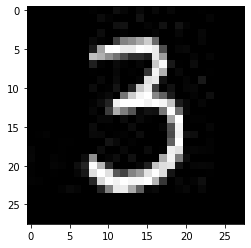

label= b''


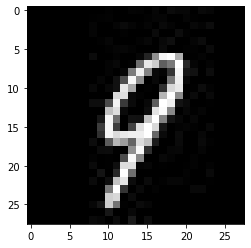

In [51]:
""" standard way to iterate tfr, to make sure the tfr format is right """

dataset = tf.data.TFRecordDataset(tfr_file_name)

image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.string),
    # var len is different
    'image': tf.io.FixedLenFeature([],tf.string),
}

def _parse_function(example_proto):
    serialized_example = tf.io.parse_single_example(example_proto, image_feature_description)
    return serialized_example


for idx, features in enumerate(dataset):
    parsed_features = _parse_function(features)
    print("label=",parsed_features['label'].numpy())    
    image=tf.io.decode_jpeg(parsed_features['image'])
    plt.imshow(np.asarray(image).reshape((28,28)),cmap = plt.cm.gray)                                        
    plt.show()
    
    if idx>=1:
        break

In [52]:
"""offset table read test"""

oft=open(oft_file_name,'rb')
idx=5
for i in range (60000):
    
    tmp=oft.read(8)
    #print(tmp)
    if(i%4000==0):
        length=struct.unpack("<Q",tmp)
        print(length[0])

0
2672383
5374539
8053940
10661888
13181595
15756600
18397086
21055369
23717478
26399802
29080008
31757528
34438147
37120997


In [53]:
""" the actual read() function """

def sparse_random_read(binfile, oft, idx):
    # read offset, 8B per instance
    #TODO: oft should be loaded to mem
    oft.seek(idx*8,0)
    tmp=oft.read(8)
    offset=struct.unpack("<Q",tmp)[0]
    print("offset=",offset)
    
    # read data length
    binfile.seek(offset,0)
    tmp=binfile.read(8)
    length=struct.unpack("<Q",tmp)[0]
    print("length=",length)
    # we already read first 8B
    record_l_from_col2=length+8
    
    # random read
    tmp=binfile.read(record_l_from_col2)
    r_data=tmp[4:-4]

    # deserialize data
    parsed_features = _parse_function(r_data)
    return parsed_features
    
    

offset= 39795040
length= 584
tf.Tensor(b'', shape=(), dtype=string)


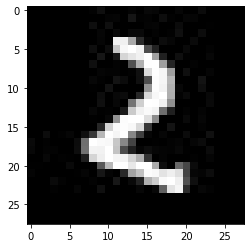

In [69]:
""" test read() function """

binfile=open(tfr_file_name,'rb')
oftfile=open(oft_file_name,'rb')
parsed_feature=sparse_random_read(binfile,oftfile, 59955)
image=tf.io.decode_jpeg(parsed_feature['image'])
print(parsed_feature['label'])
np_image=np.frombuffer(image, dtype='>B').astype(np.uint8)
plt.imshow(np.asarray(np_image).reshape((28,28)),cmap = plt.cm.gray)                                        
plt.show()

In [71]:
oft=open(oft_file_name,'rb')
page_aligned_indices = []
idx=0
for idx in range(60000):
    oft.seek(idx*8,0)
    tmp=oft.read(8)
    #print(idx)
    offset=struct.unpack("<Q",tmp)[0]
    if(offset % 4096 == 0):
        page_aligned_indices.append(idx)

print(page_aligned_indices)

[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 67, 73, 79, 86, 92, 99, 105, 111, 117, 123, 129, 136, 143, 149, 155, 162, 168, 174, 180, 186, 192, 198, 204, 210, 217, 223, 230, 236, 243, 249, 255, 261, 267, 273, 279, 286, 292, 298, 305, 311, 317, 323, 329, 335, 341, 347, 354, 360, 366, 372, 378, 384, 390, 396, 402, 408, 415, 422, 428, 434, 441, 447, 453, 459, 465, 470, 476, 483, 489, 495, 502, 508, 515, 521, 527, 533, 539, 545, 551, 557, 564, 571, 577, 584, 590, 597, 603, 609, 615, 621, 628, 634, 640, 646, 652, 658, 665, 671, 677, 683, 689, 695, 702, 709, 716, 721, 727, 734, 740, 746, 752, 758, 764, 770, 776, 783, 789, 795, 801, 807, 814, 821, 826, 831, 836, 841, 847, 853, 859, 865, 871, 877, 883, 889, 896, 903, 909, 916, 922, 928, 934, 940, 947, 953, 959, 965, 971, 977, 984, 990, 996, 1002, 1008, 1014, 1021, 1027, 1034, 1040, 1047, 1053, 1059, 1065, 1071, 1077, 1082, 1087, 1093, 1100, 1106, 1112, 1119, 1125, 1131, 1137, 1143, 1148, 1154, 1160, 1166, 1173, 1179, 1185, 1191, 1196, 1202, 1208